# Testing if Dan Foreman-Mackey's "money equation" works for my purposes.
Neglecting constant terms, his money equation is:

$$P(\{x_k\} | \gamma) = \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(q_k^{(n)}) q_k^{-\gamma}}{P(obs|q_k)} $$

## Status as of end of day on Thursday, August 12
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Next:
     - Add in observational uncertainties, and shift the measurements by appropriate amounts
     - Write code (subclass Fitters.Bayesian_LS) to fit the orbit to that information.
     - See what happens when I dial back the number of data points to a very small value.

In [44]:
# Import stuff
import numpy as np
from scipy.stats import truncnorm, lognorm, powerlaw, norm
import matplotlib.pyplot as plt
import ForwardModeling
import Fitters
import Orbit
import pandas as pd
from astropy import units as u, constants
import IMF_utils

%matplotlib inline

In [34]:
# True parameters
true_mrd_alpha = 0.4    # Mass-ratio distribution
true_error = 0.03
N_sample = 1000     # Number of stars in sample
N_mcmc = 1e6
true_mult_rate = 0.5   # Multiplicity rate
true_sep_mu = np.log(200)   # Separation mean
true_sep_sigma = np.log(10)   # Separation spread
true_ecc_alpha = 0.7   # eccentricity distribution parameter
true_min_mass = 2.0    # Minimum primary mass
true_max_mass = 6.0    # maximum primary mass

In [56]:
#Make a simulated sample.
a = np.random.lognormal(mean=true_sep_mu, sigma=true_sep_sigma, size=N_sample) * u.AU
e = ForwardModeling.truncated_expon(scale=true_ecc_alpha, Nsamp=N_sample)
q = ForwardModeling.truncated_expon(scale=true_mrd_alpha, Nsamp=N_sample)
prim_mass = IMF_utils.inverse_imf(np.random.uniform(size=N_sample), mmin=true_min_mass, mmax=true_max_mass) * u.M_sun
M0 = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
Omega = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
omega = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
sini = np.random.uniform(0, 1, size=N_sample)
i = np.arcsin(sini) * u.radian
Period = np.sqrt(4*np.pi**2*a**3 / (constants.G*(prim_mass + prim_mass*q))).to(u.year)

sample_parameters = pd.DataFrame(data=dict(a=a, e=e, q=q, M_prim=prim_mass, Period=Period.to(u.year),
                                           M0=M0.to(u.degree), big_omega=Omega.to(u.degree), 
                                           little_omega=omega.to(u.degree), i=i.to(u.degree)))
sample_parameters.head()

,M0,M_prim,Period,a,big_omega,e,i,little_omega,q
0,89.550984,2.044572,89528.545239,2556.087577,88.130892,0.000367,51.812179,355.230591,0.018820
1,47.505022,2.698197,8.744773,6.119948,335.349960,0.063767,23.735242,49.077395,0.110627
2,340.316441,2.605760,5708.123006,467.126471,13.583241,0.258060,28.368618,172.647269,0.200267
3,296.049823,2.992253,65839.454444,2801.987319,136.851830,0.100434,29.864420,228.453994,0.695600
4,20.687671,2.366706,125.394725,33.405684,57.648770,0.450578,55.622048,304.242943,0.001507


In [54]:
#sample_parameters['a'].values
a

<Quantity [  3.79062862e+01,  2.84874346e+03,  3.43966743e+02,
             2.71529623e+01,  5.11450487e+03,  2.77716511e+01,
             1.75970183e+02,  5.09137597e+02,  6.00690572e+02,
             4.77335223e+01,  1.37062019e+01,  2.61295004e+02,
             4.61415347e+02,  3.83724631e+01,  2.46241949e+01,
             2.55073718e+03,  3.43504016e+03,  1.22719542e+02,
             1.58912552e+02,  1.93159081e+02,  1.70415851e+03,
             5.29504695e+02,  2.13831341e+02,  1.42182314e+02,
             8.66766607e+01,  4.14123064e+02,  2.18871529e+02,
             1.55379927e+01,  4.14103460e+03,  2.62096795e+01,
             2.62327706e+04,  8.22544845e+01,  2.03007318e+03,
             4.10899417e+02,  5.18602360e+02,  7.66633707e+00,
             1.00674762e+02,  2.03896515e+03,  2.45108126e+03,
             9.87982251e+02,  1.35452951e+04,  1.56287476e+03,
             1.76383723e+03,  2.43096960e+00,  1.40438382e+03,
             2.01004077e+02,  3.36855007e+02,  1.761497

In [75]:
# Make some RVs and imaging observations at random times throughout the period
def sample_orbit(star, N_rv, N_imag):
    """ Sample the binary orbit represented by the 'star' structure at N_rv random times for
    RV measurements, and N_imag random times for imaging measurements
    """
    orbit = Orbit.OrbitCalculator(P=star['Period'], M0=star['M0'], a=star['a'], e=star['e'], 
                                  big_omega=star['big_omega'], little_omega=star['little_omega'],
                                  i=star['i'], q=star['q'], primary_mass=star['M_prim'])
    rv_times = np.random.uniform(0, star['Period'], size=N_rv)
    image_times = np.random.uniform(0, star['Period'], size=N_imag)
    rv_primary_measurements = orbit.get_rv(rv_times, component='primary')
    rv_secondary_measurements = rv_primary_measurements * orbit.K2 / orbit.K1
    rho_measurements, theta_measurements = orbit.get_imaging_observables(image_times)
    
    return rv_times, rv_primary_measurements, rv_secondary_measurements, image_times, rho_measurements, theta_measurements


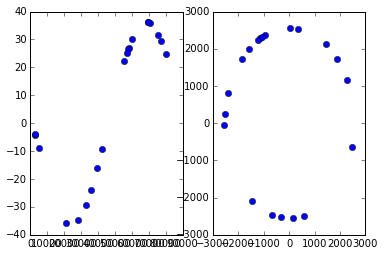

In [76]:
reload(Orbit)
t_rv, rv1, rv2, t_im, rho, theta = sample_orbit(sample_parameters.ix[0], N_rv=20, N_imag=20)
fig, axes = plt.subplots(ncols=2, nrows=1)
axes[0].plot(t_rv, rv2, 'bo')
x = rho * np.sin(theta)
y = rho * np.cos(theta)
axes[1].plot(x, y, 'bo')

In [22]:
# Define the functions I will need
def Gamma(pars, q):
    # The rate density
    gamma = pars[0]
    return (1-gamma)*q**(-gamma)

def completeness(q):
    return 1.0

def bias(q):
    return 1.0

def lnlike(pars, samp):
    summand = completeness(samp) * Gamma(pars, samp) / bias(samp)
    return np.prod(np.log(np.sum(mcmc_samples, axis=1)/N_mcmc))

In [23]:
lnlike([0.4], mcmc_samples)

nan

In [21]:
mcmc_samples.sum(axis=1).shape

(503,)

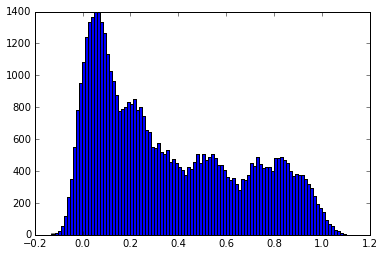

In [26]:
_ = plt.hist(mcmc_samples.flatten(), bins=100)

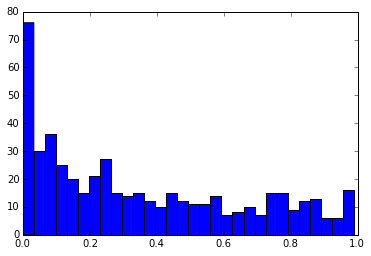

In [32]:
_ = plt.hist(binaries['q'], bins=30)
#binaries['q']